##More Advanced SparkSQL Topics

We are going to cover:
<br><br>
Creating User Defined Functions
<br>Appending a Column to a Table
<br>Rolling Sums
<br>Correlations using SQL
<br>Pivoting Data


###Getting started:
Create a SQL Context from the Spark Context, sc, which is predefined in every notebook

In [1]:
#sqlContext is used for defining Dataframes and working with SparkSQL
#use sc to create our sqlContext, sc has the connection information for the
#Spark enviroment

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

###Loading Data

A data file on world banks will downloaded from GitHub after removing any previous data that may exist


In [2]:
# In the Data Scientist Workbench (DSWB) you can prefice commands with a ! to run shell commands
# here we remove any files with the name of the file we are going to download
# then download the file

!rm world_bank.json.gz -f
!wget https://raw.githubusercontent.com/bradenrc/sparksql_pot/master/world_bank.json.gz

--2016-05-17 18:10:50--  https://raw.githubusercontent.com/bradenrc/sparksql_pot/master/world_bank.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.27.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.27.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 446287 (436K) [application/octet-stream]
Saving to: ‘world_bank.json.gz’

100%[======================================>] 446,287     --.-K/s   in 0.07s   

2016-05-17 18:10:50 (5.88 MB/s) - ‘world_bank.json.gz’ saved [446287/446287]



###Load the JSON data and create our table

In [3]:
#You can load json, text and other files using sqlContext
#unlinke an RDD, this will attempt to create a schema around the data
#self describing data works really well for this
example1_df = sqlContext.read.json("/resources/world_bank.json.gz")

#Simply use the Dataframe Object to create the table:
example1_df.registerTempTable("world_bank")

In [4]:
temp_df =  sqlContext.sql("select * from world_bank limit 2")
temp_df.toPandas()

,_id,approvalfy,board_approval_month,boardapprovaldate,borrower,closingdate,country_namecode,countrycode,countryname,countryshortname,...,sectorcode,source,status,supplementprojectflg,theme1,theme_namecode,themecode,totalamt,totalcommamt,url
0,"(52b213b38594d8a2be17c780,)",1999,November,2013-11-12T00:00:00Z,FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA,2018-07-07T00:00:00Z,Federal Democratic Republic of Ethiopia!$!ET,ET,Federal Democratic Republic of Ethiopia,Ethiopia,...,"ET,BS,ES,EP",IBRD,Active,N,"(Education for all, 100)","[(65, Education for all)]",65,130000000,130000000,http://www.worldbank.org/projects/P129828/ethi...
1,"(52b213b38594d8a2be17c781,)",2015,November,2013-11-04T00:00:00Z,GOVERNMENT OF TUNISIA,None,Republic of Tunisia!$!TN,TN,Republic of Tunisia,Tunisia,...,"BZ,BS",IBRD,Active,N,"(Other economic management, 30)","[(24, Other economic management), (54, Social ...","54,24",0,4700000,http://www.worldbank.org/projects/P144674?lang=en


#Creating  User Defined Function (UDF)

The example below will Lookup the country code<br>
<br>
Using a service "restcountries.eu" we can call the REST API and get the full Country Name:
<img src="http://restcountries.eu/img/octocat60px.png" />

In [5]:
import urllib
import json
import re


#https://restcountries.eu/rest/v1/alpha/co

def full_country_name(code):
    lower_code = code.lower()
    lower_code = re.sub(r'[^\x00-\x7F]+',' ', lower_code)
    url = "https://restcountries.eu/rest/v1/alpha/{}".format(code)
    web_data = urllib.urlopen(url).read()
    country_json = json.loads(web_data)
    
    try:
        return re.sub(r'[^\x00-\x7F]+',' ', country_json["name"])
    except:
        return 'unknown'


#test the function

print full_country_name("co")
print full_country_name("us")
print full_country_name("xx")



Colombia
United States
unknown


In [6]:
#Register the Function to be available to SparkSQL
sqlContext.registerFunction("full_country_name", full_country_name)

In [7]:
#Test the function in SQL

query = """
select
    countrycode,
    full_country_name(countrycode)
from world_bank
limit 10
"""
sqlContext.sql(query).toPandas()


,countrycode,_c1
0,ET,Ethiopia
1,TN,Tunisia
2,TV,Tuvalu
3,RY,unknown
4,LS,Lesotho
5,KE,Kenya
6,IN,India
7,CN,China
8,IN,India
9,MA,Morocco


###Adding the Country to the table\dataframe

Now we can use the function to append a column "country_name" to a new dataframe


In [8]:
query = """
select
    *,
    full_country_name(countrycode) as country_name
from world_bank
limit 10
"""

world_bank_with_country = sqlContext.sql(query)

In [9]:
print type(world_bank_with_country)

<class 'pyspark.sql.dataframe.DataFrame'>


In [10]:
world_bank_with_country.registerTempTable("world_bank_with_country")

In [11]:
query = """
select country_name, * from
world_bank_with_country
limit 2
"""
sqlContext.sql(query).toPandas()


,country_name,_id,approvalfy,board_approval_month,boardapprovaldate,borrower,closingdate,country_namecode,countrycode,countryname,...,source,status,supplementprojectflg,theme1,theme_namecode,themecode,totalamt,totalcommamt,url,country_name
0,Ethiopia,"(52b213b38594d8a2be17c780,)",1999,November,2013-11-12T00:00:00Z,FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA,2018-07-07T00:00:00Z,Federal Democratic Republic of Ethiopia!$!ET,ET,Federal Democratic Republic of Ethiopia,...,IBRD,Active,N,"(Education for all, 100)","[(65, Education for all)]",65,130000000,130000000,http://www.worldbank.org/projects/P129828/ethi...,Ethiopia
1,Tunisia,"(52b213b38594d8a2be17c781,)",2015,November,2013-11-04T00:00:00Z,GOVERNMENT OF TUNISIA,None,Republic of Tunisia!$!TN,TN,Republic of Tunisia,...,IBRD,Active,N,"(Other economic management, 30)","[(24, Other economic management), (54, Social ...","54,24",0,4700000,http://www.worldbank.org/projects/P144674?lang=en,Tunisia


##Rolling Sums

Correlated Sub Select is not currently supported, so there are a few options to get a rolling sum. The easiest is to self join.

In [12]:
#First let's create a dataframe with some random quarterly sales data
import random

sales_data = []

for x in range(1,20):
    random_sales = int(random.random() * 100)
    random_quarter = int(random.randrange(1,5))
    sales_data.append([x, random_quarter, random_sales])

#create the RDD with the data
sales_data_rdd = sc.parallelize(sales_data)


In [15]:
from pyspark.sql import Row

#now create the dataframe and name the columns
sales_data_df = sales_data_rdd.map(lambda x: Row(id=x[0], quarter=x[1], sales=x[2])).toDF()
sales_data_df.registerTempTable("sales_data")
sales_data_df.show()

+---+-------+-----+
| id|quarter|sales|
+---+-------+-----+
|  1|      4|   85|
|  2|      3|   50|
|  3|      1|   81|
|  4|      1|   91|
|  5|      4|   23|
|  6|      3|   87|
|  7|      4|   11|
|  8|      2|   32|
|  9|      1|   24|
| 10|      4|   96|
| 11|      2|   98|
| 12|      1|   29|
| 13|      2|   55|
| 14|      2|   38|
| 15|      1|   95|
| 16|      4|   75|
| 17|      3|   83|
| 18|      3|   34|
| 19|      2|   59|
+---+-------+-----+



In [14]:
sqlContext.sql("select * from sales_data limit 5").toPandas()

,id,quarter,sales
0,1,4,85
1,2,3,50
2,3,1,81
3,4,1,91
4,5,4,23


In [18]:
#query to capture the rolling sum by quarter ordered by ID
query = """
select
    s.id,
    s.sales,
    s.quarter,
    sum(ss.sales) as Rolling_Sum
from
    sales_data s
inner join sales_data ss on
    s.id >= ss.id
    and s.quarter = ss.quarter
group by
    s.id, s.sales, s.quarter
order by s.quarter, s.id
"""
pd = sqlContext.sql(query).toPandas()
pd

,id,sales,quarter,Rolling_Sum
0,3,81,1,81
1,4,91,1,172
2,9,24,1,196
3,12,29,1,225
4,15,95,1,320
5,8,32,2,32
6,11,98,2,130
7,13,55,2,185
8,14,38,2,223
9,19,59,2,282


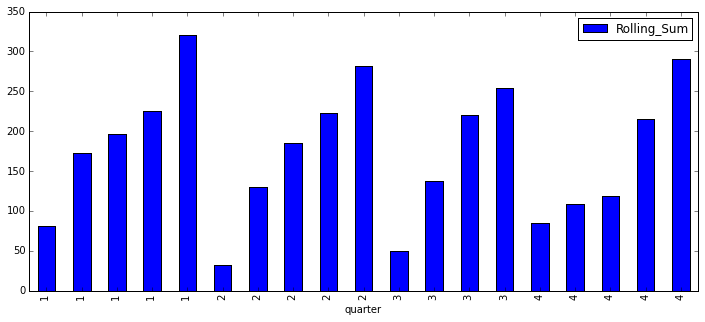

In [24]:
%matplotlib inline 
import matplotlib.pyplot as plt, numpy as np

pd.plot(kind='bar', y='Rolling_Sum', x='quarter', figsize=(12, 5))


###Calculating Correlation using SQL

We can use the built in function corr to run a correlation calculation (Pearson), across columns. First we can create a table with a rolling sum by ID, the correlation should be perfect.

In [29]:
#Create new table and dataframe to run the calculation against
query = """
select
    s.id,
    s.sales,
    sum(ss.sales) as Rolling_Sum
from
    sales_data s
inner join sales_data ss on
    s.id >= ss.id
group by
    s.id, s.sales
order by s.id
"""
p_corr_df = sqlContext.sql(query)
p_corr_df.registerTempTable("p_corr")
p_corr_df.show()


+---+-----+-----------+
| id|sales|Rolling_Sum|
+---+-----+-----------+
|  1|   85|         85|
|  2|   50|        135|
|  3|   81|        216|
|  4|   91|        307|
|  5|   23|        330|
|  6|   87|        417|
|  7|   11|        428|
|  8|   32|        460|
|  9|   24|        484|
| 10|   96|        580|
| 11|   98|        678|
| 12|   29|        707|
| 13|   55|        762|
| 14|   38|        800|
| 15|   95|        895|
| 16|   75|        970|
| 17|   83|       1053|
| 18|   34|       1087|
| 19|   59|       1146|
+---+-----+-----------+



In [30]:
#to run the correlation, simply call corr(Column1, Column2)
query = """
select
    corr(id, Rolling_Sum) as corr
from
    p_corr
"""
sqlContext.sql(query).show()


+------------------+
|              corr|
+------------------+
|0.9960716530998973|
+------------------+



In [31]:
#You can also group by specific data, so take the example of the quarterly rolling sums

query = """
select
    s.id,
    s.sales,
    s.quarter,
    sum(ss.sales) as Rolling_Sum
from
    sales_data s
inner join sales_data ss on
    s.id >= ss.id
    and s.quarter = ss.quarter
group by
    s.id, s.sales, s.quarter
order by s.quarter, s.id
"""

q_p_corr = sqlContext.sql(query)
q_p_corr.registerTempTable("q_p_corr")
q_p_corr.show()


+---+-----+-------+-----------+
| id|sales|quarter|Rolling_Sum|
+---+-----+-------+-----------+
|  3|   81|      1|         81|
|  4|   91|      1|        172|
|  9|   24|      1|        196|
| 12|   29|      1|        225|
| 15|   95|      1|        320|
|  8|   32|      2|         32|
| 11|   98|      2|        130|
| 13|   55|      2|        185|
| 14|   38|      2|        223|
| 19|   59|      2|        282|
|  2|   50|      3|         50|
|  6|   87|      3|        137|
| 17|   83|      3|        220|
| 18|   34|      3|        254|
|  1|   85|      4|         85|
|  5|   23|      4|        108|
|  7|   11|      4|        119|
| 10|   96|      4|        215|
| 16|   75|      4|        290|
+---+-----+-------+-----------+



In [32]:
#The corr function is an aggregate function (like SUM, MIN, MAX, etc.), simply group and it will
#calculate for each group.

query = """
select
    quarter,
    corr(id, Rolling_Sum) as corr
from
    q_p_corr
group by quarter
"""
sqlContext.sql(query).show()


+-------+------------------+
|quarter|              corr|
+-------+------------------+
|      1|0.9271993505741362|
|      2|0.9669139093688827|
|      3|0.9754696396838656|
|      4|0.9635279956379715|
+-------+------------------+



###Pivoting Data

Spark SQL provides the ability to pivot data to create pivot tables using the DataFrame API in conjuntion with Spark SQL.

In [34]:
#Let's create a dataframe to demonstrate pivoting data.
#Similar to what we did above, but now with multiple quarter entries per (product) id.

import random

sales_data_2 = []

for y in range(1,10):

    for x in range(1,20):
        random_sales = int(random.random() * 100)
        random_quarter = int(random.randrange(1,5))
        sales_data_2.append([x, random_quarter, random_sales])

#create the RDD with the data
sales_data_2_rdd = sc.parallelize(sales_data_2)

In [35]:
#Create the dataframe and name the columns
sales_data_2_df = sales_data_2_rdd.map(lambda x: Row(id=x[0], quarter=x[1], sales=x[2])).toDF()
sales_data_2_df.registerTempTable("sales_data_2")
sales_data_2_df.show(10)

+---+-------+-----+
| id|quarter|sales|
+---+-------+-----+
|  1|      1|   32|
|  2|      3|   65|
|  3|      1|   82|
|  4|      3|   69|
|  5|      1|   77|
|  6|      4|   81|
|  7|      2|   13|
|  8|      1|   68|
|  9|      4|   10|
| 10|      1|    4|
+---+-------+-----+
only showing top 10 rows



In [36]:
#query to report on total sales for each (product) id by quarter using a standard Group By
#Not a rolling average as we did above
query_2 = """
select
    quarter,
    id,
    sum(sales) as SumForQuarter
from
    sales_data_2 
group by
    quarter, id
order by quarter, id
"""
df_2 = sqlContext.sql(query_2)
df_2.show(10)

+-------+---+-------------+
|quarter| id|SumForQuarter|
+-------+---+-------------+
|      1|  1|           61|
|      1|  2|           97|
|      1|  3|          170|
|      1|  4|          138|
|      1|  5|          205|
|      1|  6|           38|
|      1|  7|          100|
|      1|  8|          179|
|      1|  9|           48|
|      1| 10|          364|
+-------+---+-------------+
only showing top 10 rows



In [37]:
#Pivot the original table on quarter summing on sales by (product) id
sales_data_pivot_df = sales_data_2_df.groupBy("id").pivot("quarter", [1, 2, 3, 4]).sum("sales").withColumnRenamed("1", "Q1").withColumnRenamed("2", "Q2").withColumnRenamed("3", "Q3").withColumnRenamed("4", "Q4")
sales_data_pivot_df.show()

+---+----+----+----+----+
| id|  Q1|  Q2|  Q3|  Q4|
+---+----+----+----+----+
|  1|  61| 156| 349|null|
|  2|  97|  74| 230| 221|
|  3| 170|  57|null| 196|
|  4| 138|  90| 160| 167|
|  5| 205|  82|  16|   4|
|  6|  38|  89|null| 311|
|  7| 100|  71|  90| 102|
|  8| 179| 164| 111|  27|
|  9|  48|  75| 143| 181|
| 10| 364|null|  78|  97|
| 11|  75| 249|null| 194|
| 12|  42|null| 167| 235|
| 13|  67| 322| 160|null|
| 14|null|  98|  78| 126|
| 15|  66|  54| 104| 294|
| 16|  71|  26| 146| 110|
| 17| 196| 112| 307|  12|
| 18| 165|  64|  92|  52|
| 19| 131|  28|  23| 262|
+---+----+----+----+----+

